# Model Evaluation
This script evaluates the student and teacher model for speed, compression and cosine similarity for the three datasets.
Does not include downstream task testing. Check sentiment classifier / banking 77 for that!

## Installs, Load Model, Data and Set Arguments

In [1]:
import seaborn as sns
import pickle
import torch
import numpy as np
import itertools
import tqdm
from tqdm import tqdm
import eval_funcs
from eval_funcs import evaluate_inference, vis_comparatively, count_parameters, evaluate_compression, evaluate_performance
from sagemaker import get_execution_role
import boto3
from utils import read_torch, load_pickle
from transformers import AutoConfig, AutoModel
from distil_funcs import *
from copy import deepcopy

In [3]:
# if testing opensubtitles performance
test_file = '/home/ec2-user/SageMaker/data/test.pkl'
encoded_test_set = load_pickle(test_file)

In [2]:
# if testing tweets performance
import pandas as pd
sentiment_test_data = pd.read_csv('data/twitter-2016train-A.txt', sep='\t', header=None)
sentiment_test_data = sentiment_test_data[2].tolist()
from transformers import AutoTokenizer
MAX_SEQ = 32
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")
encoded_test_set = tokenizer(sentiment_test_data, padding=True, truncation=True, max_length=MAX_SEQ, return_tensors='pt')

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [3]:
sentiment_test_data = pd.read_csv('data/twitter-2016train-A.txt', sep='\t', header=None)

In [6]:
sentiment_test_data.drop(columns=[0], inplace=True)
sentiment_test_data

,1,2
0,negative,dear @Microsoft the newOoffice for Mac is grea...
1,negative,@Microsoft how about you make a system that do...
2,negative,I may be ignorant on this issue but... should ...
3,negative,"Thanks to @microsoft, I just may be switching ..."
4,neutral,If I make a game as a #windows10 Universal App...
...,...,...
5863,positive,@Racalto_SK ok good to know. Punting at MetLif...
5864,neutral,everyone who sat around me at metlife was so a...
5865,neutral,what giants or niners fans would wanna go to t...
5866,positive,Anybody want a ticket for tomorrow Colombia vs...


In [11]:
sentiment_test_data[:20].to_csv('sentiment_samples.csv', sep=' ')

In [9]:
# if testing banking 77 performance
from transformers import AutoTokenizer
import pandas as pd
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")
train_path = "data/banking77/train.csv"
test_path = 'data/banking77/test.csv'

en_test_data = pd.read_csv(test_path)
encoded_test_set = tokenizer(en_test_data.text.to_list(), padding=True, truncation=True, max_length=64, return_tensors='pt')

In [14]:
en_test_data = pd.read_csv(test_path)
en_test_data.to_csv('banking_samples.csv', index=False)

In [4]:
# Load Teacher Model for Evaluation
DEVICE = torch.device('cuda')
teacher_model = load_teacher(device=DEVICE)

Some weights of the model checkpoint at sentence-transformers/LaBSE were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# Load Student Model for Evaluation

# 1. Load Config of student

student_config = {
    'd_model': 768, # hidden dim of model
    'heads': 12, # attention heads
    'dropout':0.1, # dropout in network except ffn
    'dropout_ffn':0.4, # dropout in ffn 
    'd_ff': 12, # num features in FFN hidden layer
    'n_layers': 2, # num of transformer layers
    'n_experts': 320, # number of FFN experts
    'load_balancing_loss_ceof': 0.01, # load balancing co-eff, encourages expert diversity
    'is_scale_prob': True, # whether to scale the selected expert outputs by routing probability
    'drop_tokens': False, # whether to drop tokens
    'capacity_factor':1.25, # capacity factor - seemed to work best in Switch Transformer
}

# 3. Create student model
word_embeddings = deepcopy(teacher_model.get_input_embeddings())
compressed_word_embeddings = word_embedding_compression(word_embeddings, student_config['d_model'])
student_model = LaBSE_Switch(config=student_config, word_embeddings_module=compressed_word_embeddings)

# 4. Load state_dict() of trained student
path = 's3://eu1-sagemaker-bucket/borisbubla/experiments/10000.0k/switch/LR0.0001LAY2EXP320D_FF12TEMP9TIME-20210621-142400/Distil_LaBSE_2L_320E_12D'
file = read_torch(path)
student_model.load_state_dict(file)
student_model.eval()

LaBSE_Switch(
  (switch_model): SwitchTransformer(
    (layers): TypedModuleList(
      (0): SwitchTransformerLayer(
        (attn): MultiHeadAttention(
          (query): PrepareForMultiHeadAttention(
            (linear): Linear(in_features=768, out_features=768, bias=True)
          )
          (key): PrepareForMultiHeadAttention(
            (linear): Linear(in_features=768, out_features=768, bias=True)
          )
          (value): PrepareForMultiHeadAttention(
            (linear): Linear(in_features=768, out_features=768, bias=True)
          )
          (softmax): Softmax(dim=1)
          (output): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): SwitchFeedForward(
          (experts): TypedModuleList(
            (0): FeedForward(
              (layer1): Linear(in_features=768, out_features=12, bias=True)
              (layer2): Linear(in_features=12, out_features=768, bias=True)
        

In [6]:
# Arguments
num_samples = 100 # higher, better accuracy, longer compute
batch_sizes = [1,64,128, 256, 512] # change based on training data size
num_workers = [4]
sns.set_style('whitegrid')

## Evaluate Inference

### Evaluate Teacher

#### Teacher GPU

In [16]:
teacher_means_cuda, teacher_std_devs_cuda = evaluate_inference(model=teacher_model,
                                                     encoded_eval_data=encoded_test_set, 
                                                     cpu_or_cuda='cuda',
                                                     num_samples = num_samples ,
                                                     batch_sizes=batch_sizes,
                                                     num_workers=num_workers)

100%|██████████| 5/5 [02:14<00:00, 26.94s/it]


In [17]:
for batch,mean,std_dev in zip(batch_sizes,teacher_means_cuda,teacher_std_devs_cuda):
    
    for worker,me,std, in zip(num_workers,mean,std_dev):
        print('Batch size: ',batch,' Num_workers: ',worker,' Mean inf: ',me,' Std dev: ',std)
    print('\n')

Batch size:  1  Num_workers:  4  Mean inf:  15.156936998367309  Std dev:  2.4999426259128517


Batch size:  64  Num_workers:  4  Mean inf:  225.45462661743164  Std dev:  23.09294697507438


Batch size:  128  Num_workers:  4  Mean inf:  352.2896186828613  Std dev:  185.63865627988346


Batch size:  256  Num_workers:  4  Mean inf:  351.89743255615235  Std dev:  438.8074760443247


Batch size:  512  Num_workers:  4  Mean inf:  351.2984002685547  Std dev:  707.4772763202033




Text(0.5, 0, 'Batch Size')

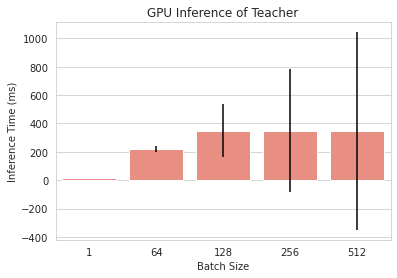

In [8]:
ax = sns.barplot(x=batch_sizes, y=list(np.array(teacher_means_cuda).T[0]), yerr=list(np.array(teacher_std_devs_cuda).T[0]), color='salmon')
ax.set_title('GPU Inference of Teacher')
ax.set_ylabel('Inference Time (ms)')
ax.set_xlabel('Batch Size')

#### Teacher CPU

In [9]:
teacher_means_cpu, teacher_std_devs_cpu = evaluate_inference(model=teacher_model,
                                                     encoded_eval_data=encoded_test_set, 
                                                     cpu_or_cuda='cpu',
                                                     num_samples = num_samples ,
                                                     batch_sizes=batch_sizes,
                                                     num_workers=num_workers)

100%|██████████| 5/5 [28:20<00:00, 340.05s/it]


In [10]:
for batch,mean,std_dev in zip(batch_sizes,teacher_means_cpu,teacher_std_devs_cpu):
    for worker,me,std, in zip(num_workers,mean,std_dev):
        print('Batch size: ',batch,' Num_workers: ',worker,' Mean inf: ',me,' Std dev: ',std)
    print('\n')

Batch size:  1  Num_workers:  4  Mean inf:  88.12821464538574  Std dev:  14.965077695751928


Batch size:  64  Num_workers:  4  Mean inf:  2833.946457519531  Std dev:  341.89436440586996


Batch size:  128  Num_workers:  4  Mean inf:  4557.947492065429  Std dev:  2416.636276429955


Batch size:  256  Num_workers:  4  Mean inf:  4528.903330688477  Std dev:  5655.677364358159


Batch size:  512  Num_workers:  4  Mean inf:  4957.18333984375  Std dev:  10012.730304453027




Text(0.5, 0, 'Batch Size')

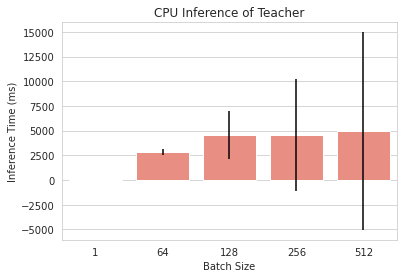

In [11]:
ax = sns.barplot(x=batch_sizes, y=list(np.array(teacher_means_cpu).T[0]), yerr=list(np.array(teacher_std_devs_cpu).T[0]), color='salmon')
ax.set_title('CPU Inference of Teacher')
ax.set_ylabel('Inference Time (ms)')
ax.set_xlabel('Batch Size')

### Evaluate Student

#### Student GPU

In [11]:
student_means_cuda, student_std_devs_cuda = evaluate_inference(model=student_model,
                                                     encoded_eval_data=encoded_test_set, 
                                                     cpu_or_cuda='cuda',
                                                     num_samples = num_samples ,
                                                     batch_sizes=batch_sizes,
                                                     num_workers=num_workers)

100%|██████████| 5/5 [00:34<00:00,  6.83s/it]


In [12]:
for batch,mean,std_dev in zip(batch_sizes,student_means_cuda,student_std_devs_cuda):
    for worker,me,std, in zip(num_workers,mean,std_dev):
        print('Batch size: ',batch,' Num_workers: ',worker,' Mean inf: ',me,' Std dev: ',std)
    print('\n')

Batch size:  1  Num_workers:  4  Mean inf:  121.18754043579102  Std dev:  12.712735424422267


Batch size:  64  Num_workers:  4  Mean inf:  86.63285285949706  Std dev:  88.56086231019695


Batch size:  128  Num_workers:  4  Mean inf:  51.48945358276367  Std dev:  89.67428027494574


Batch size:  256  Num_workers:  4  Mean inf:  34.09651542663574  Std dev:  89.47392119776838


Batch size:  512  Num_workers:  4  Mean inf:  26.436842422485352  Std dev:  100.1795762683161




Text(0.5, 0, 'Batch Size')

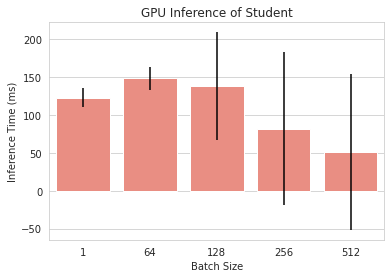

In [20]:
ax = sns.barplot(x=batch_sizes, y=list(np.array(student_means_cuda).T[0]), yerr=list(np.array(student_std_devs_cuda).T[0]), color='salmon')
ax.set_title('GPU Inference of Student')
ax.set_ylabel('Inference Time (ms)')
ax.set_xlabel('Batch Size')

#### Student CPU

In [13]:
student_means_cpu, student_std_devs_cpu = evaluate_inference(model=student_model,
                                                     encoded_eval_data=encoded_test_set, 
                                                     cpu_or_cuda='cpu',
                                                     num_samples = num_samples ,
                                                     batch_sizes=batch_sizes,
                                                     num_workers=num_workers)

100%|██████████| 5/5 [02:45<00:00, 33.16s/it]


In [14]:
for batch,mean,std_dev in zip(batch_sizes,student_means_cpu,student_std_devs_cpu):
    for worker,me,std, in zip(num_workers,mean,std_dev):
        print('Batch size: ',batch,' Num_workers: ',worker,' Mean inf: ',me,' Std dev: ',std)
    print('\n')

Batch size:  1  Num_workers:  4  Mean inf:  74.9573346710205  Std dev:  9.627934754068367


Batch size:  64  Num_workers:  4  Mean inf:  329.7455450439453  Std dev:  340.7117674342895


Batch size:  128  Num_workers:  4  Mean inf:  335.79427520751955  Std dev:  595.5270451763504


Batch size:  256  Num_workers:  4  Mean inf:  444.18539276123045  Std dev:  1201.7682224457646


Batch size:  512  Num_workers:  4  Mean inf:  444.14616424560546  Std dev:  1749.8861146475756




Text(0.5, 0, 'Batch Size')

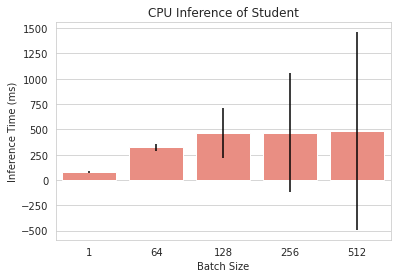

In [25]:
ax = sns.barplot(x=batch_sizes, y=list(np.array(student_means_cpu).T[0]), yerr=list(np.array(student_std_devs_cpu).T[0]), color='salmon')
ax.set_title('CPU Inference of Student')
ax.set_ylabel('Inference Time (ms)')
ax.set_xlabel('Batch Size')

### Visualise Comparatively

In [11]:
student_names = ['DistilLaBSE_2L_1E_768D', 'DistilLaBSE_2L_40E_96D', 'DistilLaBSE_2L_320E_12D']

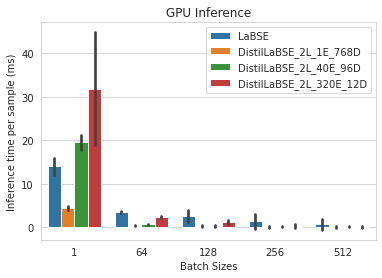

In [16]:
# GPU
vis_comparatively_per_sentence(batch_sizes, teacher_means=labse_mps_cuda, teacher_std_devs=labse_sps_cuda, 
                               student_means=student1_mps_gpu, student_std_devs=student1_sps_gpu, 
                               student_means2=student2_mps_gpu, student_std_devs2=student2_sps_gpu, 
                               student_means3=student3_mps_gpu, student_std_devs3=student3_sps_gpu, 
                               title='GPU Inference', student_names=student_names)

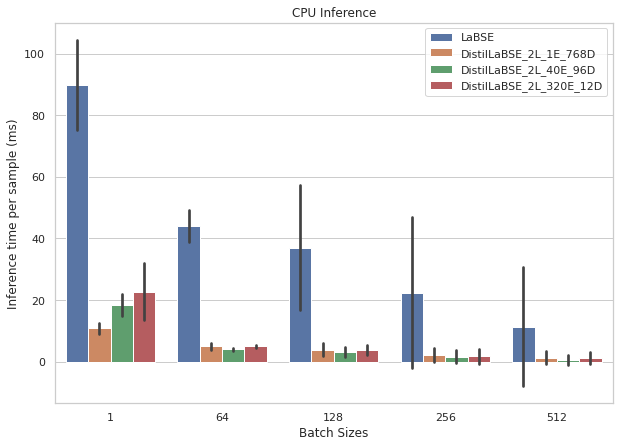

In [17]:
# CPU
vis_comparatively_per_sentence(batch_sizes, teacher_means=labse_mps_cpu, teacher_std_devs=labse_sps_cpu, 
                               student_means=student1_mps_cpu, student_std_devs=student1_sps_cpu, 
                               student_means2=student2_mps_cpu, student_std_devs2=student2_sps_cpu, 
                               student_means3=student3_mps_cpu, student_std_devs3=student3_sps_cpu, 
                               title='CPU Inference', student_names=student_names)

In [ ]:
vis_comparatively(batch_sizes, teacher_means_cuda, teacher_std_devs_cuda, student_means_cuda, student_std_devs_cuda, title='GPU Inference', student_name=student_names)

In [ ]:
vis_comparatively(batch_sizes, teacher_means_cpu, teacher_std_devs_cpu, student_means_cpu, student_std_devs_cpu, title='CPU Inference', student_name='DistilLaBSE_2L_1E_768D')

## Evaluate Compression

In [7]:
teacher_parm, student_parm, compression = evaluate_compression(teacher_model, student_model)
print("Compression: ", compression, "\nTeacher Parm: ",teacher_parm, "\nStudent Parm: ",student_parm)

Compression:  1.2 
Teacher Parm:  470926848 
Student Parm:  393163010


## Evaluate Loss Performance
Performance here is defined by user as a metric of student compared to teacher, e.g. cosine embedding, MSE.

In [10]:
performance = evaluate_performance(teacher_model, student_model, encoded_test_set,
                     metric=cosine_similarity, batch_size=1)
print("\nPerformance: ",performance)

100%|██████████| 2000/2000 [05:04<00:00,  6.58it/s]


Performance:  0.60871315
